# Data downloaded from [here](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation)

All BraTS multimodal scans are available as NIfTI files (.nii.gz) and describe a) native (T1) and b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes.

Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1).

# IMPORTANT: Apparently training data 355's segmentation file is named incorrectly in the original dataset; manual renaming to the correct naming convention is required to prevent errors 
### Alternatively, skip 355 by uncommenting the appropriate line of code under the "Preprocessing" section

### Code referenced from [this kaggle notebook](https://www.kaggle.com/code/polomarco/brats20-3dunet-3dautoencoder/data)



In [1]:
from tqdm import tqdm
import os
import time
from datetime import datetime
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau


import albumentations as A
from albumentations import Compose

import warnings
warnings.simplefilter("ignore")

In [2]:
# Global config class
class GlobalConfig:
    # Global config class
    root_dir = './BraTS2020'
    train_root_dir = './BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    test_root_dir = './BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
    # CSV where patient ID, path and fold information will be stored
    path_to_csv = './fold_data.csv'
    # Where your pretrained model is stored (Specifically for the 3DUnet architecture implemented here)
    pretrained_model_path = './BraTS2020Logs/model_by_original_notebook_author.pth'
    # Where train log is stored; each row (epoch) consists of train/val loss, dice score and jaccard score.  
    train_logs_path = './BraTS2020Logs3DUnetBCEDice_Resized' #TO DO: Change this for changes in different hyperparam/Model 
    # for reproducibility
    seed = 42


def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


def load_img(file_path):
    data = nib.load(file_path)
    data = np.asarray(data.dataobj)
    return data

config = GlobalConfig()
seed_everything(config.seed)
if not os.path.isdir(config.train_logs_path):
    os.mkdir(config.train_logs_path)


# Visualisations

img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)
mask unique -> [0 1 2 4]


Text(0.5, 0.98, 'Multimodal Scans -  Data | Manually-segmented mask - Target')

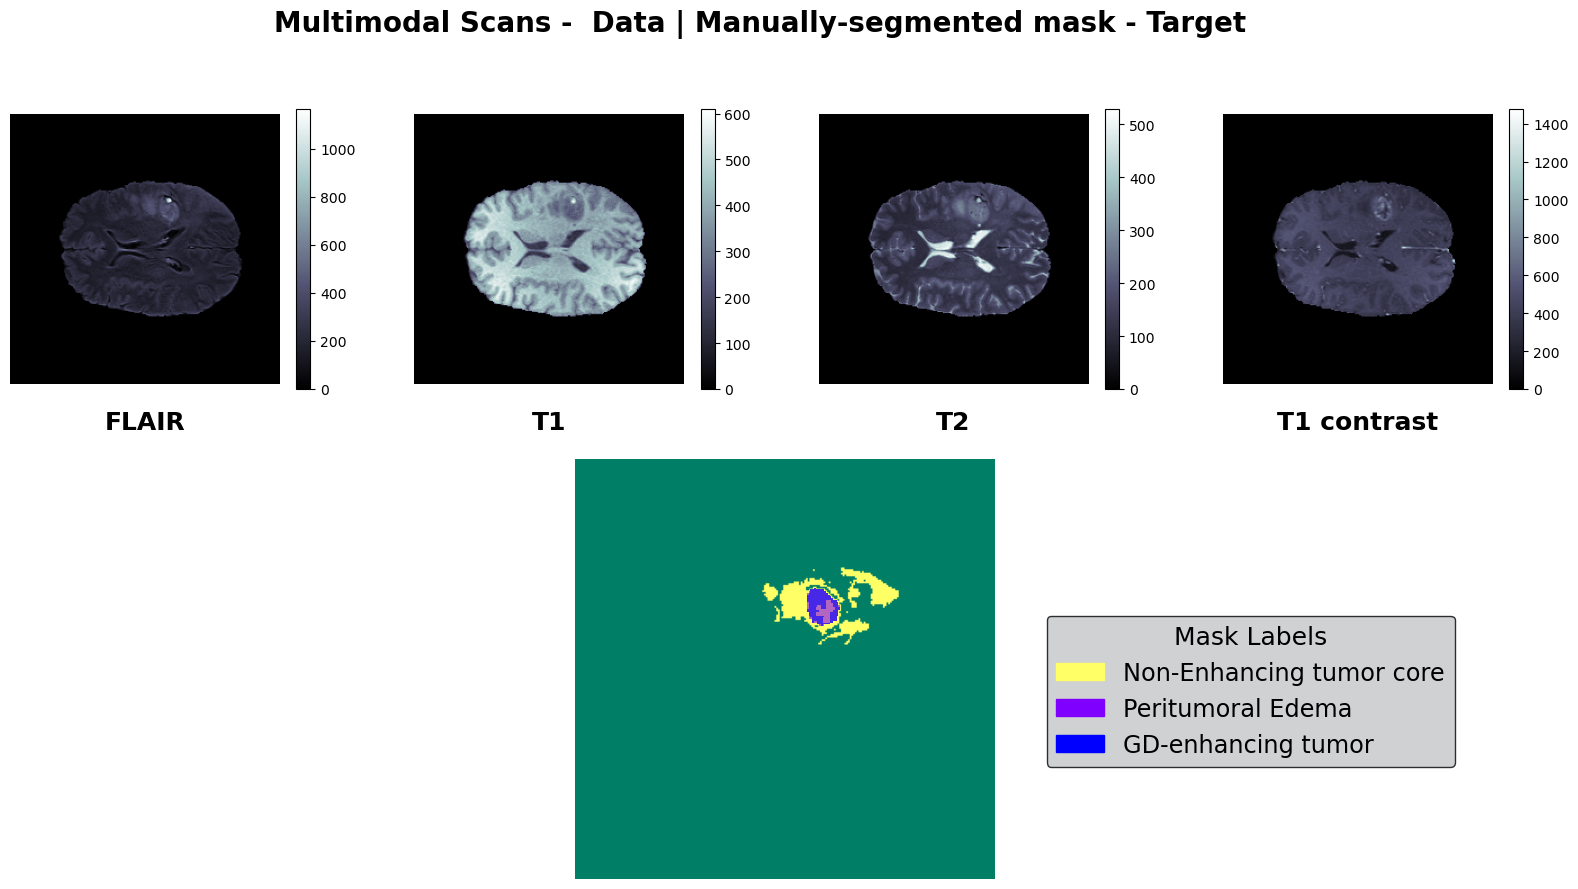

In [3]:
# Change these to visualise brain MRIs of different patients, and at different slices 
PATIENT_IDX = 10 # 1 - 369
SLICE_IDX = 85 # 0 - 154


sample_filename = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_flair.nii"
sample_filename_mask = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_seg.nii"

sample_img = load_img(sample_filename)
sample_mask = load_img(sample_filename_mask)

sample_filename2 = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_t1.nii"
sample_img2 = load_img(sample_filename2)

sample_filename3 = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_t2.nii"
sample_img3 = load_img(sample_filename3)

sample_filename4 = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_t1ce.nii"
sample_img4 = load_img(sample_filename4)

# (240, 240, 155), corresponding to height, width and depth
print("img shape ->", sample_img.shape)  
print("mask shape ->", sample_mask.shape) 
# [0,1,2,4], corresponding to the background (BG — label 0), necrotic and non-enhancing tumor core (NCR/NET — label 1), the peritumoral edema (ED — label 2) and GD-enhancing tumor (ET — label 4)
print("mask unique ->", np.unique(sample_mask)) 

# In the BraTS challenge, the segmentation performance is evaluated on three partially overlapping sub-regions of tumors,
# namely, whole tumor (WT), tumor core (TC), and enhancing tumor (ET).
# The WT is the union of ED, NCR/NET, and ET, while the TC includes NCR/NET and ET.
# We hence create 3 sets of mask. This will eventually be stacked upon each other during preprocessing in the Dataset Class.
mask_WT = sample_mask.copy()
mask_WT[mask_WT == 1] = 1
mask_WT[mask_WT == 2] = 1
mask_WT[mask_WT == 4] = 1

mask_TC = sample_mask.copy()
mask_TC[mask_TC == 1] = 1
mask_TC[mask_TC == 2] = 0
mask_TC[mask_TC == 4] = 1

mask_ET = sample_mask.copy()
mask_ET[mask_ET == 1] = 0
mask_ET[mask_ET == 2] = 0
mask_ET[mask_ET == 4] = 1


# https://matplotlib.org/3.3.2/gallery/images_contours_and_fields/plot_streamplot.html#sphx-glr-gallery-images-contours-and-fields-plot-streamplot-py
# https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib


fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
flair = ax0.imshow(sample_img[:, :, SLICE_IDX], cmap='bone') # Show all columns and rows, but a specific slice index
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

#  Varying density along a streamline
ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(sample_img2[:, :, SLICE_IDX], cmap='bone')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)

#  Varying density along a streamline
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(sample_img3[:, :, SLICE_IDX], cmap='bone')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)

#  Varying density along a streamline
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(sample_img4[:, :, SLICE_IDX], cmap='bone')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)

#  Varying density along a streamline
ax4 = fig.add_subplot(gs[1, 1:3])

#ax4.imshow(np.ma.masked_where(mask_WT[:,:,SLICE_IDX]== False,  mask_WT[:,:,SLICE_IDX]), cmap='summer', alpha=0.6)
l1 = ax4.imshow(mask_WT[:, :, SLICE_IDX], cmap='summer',)
l2 = ax4.imshow(np.ma.masked_where(mask_TC[:, :, SLICE_IDX] == False,  mask_TC[:, :, SLICE_IDX]), cmap='rainbow', alpha=0.6)
l3 = ax4.imshow(np.ma.masked_where(mask_ET[:, :, SLICE_IDX] == False, mask_ET[:, :, SLICE_IDX]), cmap='winter', alpha=0.6)

ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

_ = [ax.set_axis_off() for ax in [ax0, ax1, ax2, ax3, ax4]]

colors = [im.cmap(im.norm(1)) for im in [l1, l2, l3]]
labels = ['Non-Enhancing tumor core',
          'Peritumoral Edema ', 'GD-enhancing tumor']
patches = [mpatches.Patch(
    color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4, fontsize='xx-large',
           title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target",
             fontsize=20, weight='bold')

# fig.savefig("data_sample.png", format="png",  pad_inches=0.2,
#             transparent=False, bbox_inches='tight')
# fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2,
#             transparent=False, bbox_inches='tight')


# Preprocessing

### Mapping different patients (and the paths to their data) to different training folds; Fold 0 will be used as validation set; rest will be used as training set

In [4]:
survivalInfoPath = f"{config.train_root_dir}/survival_info.csv"
nameMappingPath = f"{config.train_root_dir}/name_mapping.csv"
survival_info_df = pd.read_csv(survivalInfoPath)
name_mapping_df = pd.read_csv(nameMappingPath)

name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True) 


df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")
df = df[["Brats20ID"]]
paths = []
for _, row  in df.iterrows():
    
    id_ = row['Brats20ID']
    path = os.path.join(config.train_root_dir, id_)
    paths.append(path)
    
df['path'] = paths

train_data = df

"""Uncomment the following if skipping number 355 due to errors"""
# train_data = train_data.loc[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True, )

kf = KFold(n_splits=7, random_state=config.seed, shuffle=True)
for i, (train_index, val_index) in enumerate(kf.split(train_data)):
    # assign all rows at val_index to the ith fold
    train_data.loc[val_index, "fold"] = i


train_data.to_csv(config.path_to_csv, index=False)


# Dataset DataLoader

### TO-DO: Try different data augmentation techniques

In [5]:
class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str="test", do_resizing: bool=False):
        # Dataframe containing patient, path and fold mapping information
        self.df = df
        # "train" "valid" or "test". Determines whether to apply preprocessing
        self.phase = phase
        self.augmentations = self.get_augmentations(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        self.do_resizing = do_resizing
        
    def __len__(self): 
        return self.df.shape[0]
    
    def __getitem__(self, idx): # Makes class accessible by square-bracket notations; determines behaviour upon square-bracket access
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        images = []
        # load all modalities(t1, t1ce, t2, flair)
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)#.transpose(2, 0, 1)
            
            if self.do_resizing:
                img = self.resize(img)
    
            img = self.normalize(img)
            images.append(img)
        # stack all 4 modalities into single array as model input
        img = np.stack(images)
        # move axes of array to new position; 
        # original shape - (4,240,240,155) -> (4,155,240,240) - new shape; facilitates input into 3DUnet model
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
        
        mask_path =  os.path.join(root_path, id_ + "_seg.nii")
        mask = self.load_img(mask_path)
        
        if self.do_resizing:
            mask = self.resize(mask)
            mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
            mask = np.clip(mask, 0, 1)
        # Creates and stacks appropriate (possibly overlapping) masks as per BraTS challenge. More info in function.
        mask = self.preprocess_mask_labels(mask)

        # Peform augmentations
        augmented = self.augmentations(image=img.astype(np.float32), mask=mask.astype(np.float32))
        img = augmented['image']
        mask = augmented['mask']

        # Returns dictionary with Id, image (x) and mask (y) in train/val phase, else return only id and image (x) in test phase
        return {
            "Id": id_,
            "image": img,
            "mask": mask,
        }
    # TO-DO: Implement possible augmentations here? Lower priority for now
    def get_augmentations(self, phase):
        list_transforms = []
        list_trfms = Compose(list_transforms)
        return list_trfms
    
    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
    
    def resize(self, data: np.ndarray):
        data = resize(data, (224, 224, 128), preserve_range=True)
        return data
    
    def preprocess_mask_labels(self, mask: np.ndarray):
        # In the BraTS challenge, the segmentation performance is evaluated on three partially overlapping sub-regions of tumors,
        # namely, whole tumor (WT), tumor core (TC), and enhancing tumor (ET).
        # The WT is the union of ED, NCR/NET, and ET, while the TC includes NCR/NET and ET.

        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1

        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1

        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        return mask

        

In [6]:
def get_dataloaders(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    # phase: str,
    val_fold: int = 0, # Choose which fold to be the validation fold
    test_fold: int = 1,
    batch_size: int = 1,
    num_workers: int = 4,
    do_resizing: bool = False,
):
    assert(val_fold != test_fold)
    
    df = pd.read_csv(path_to_csv)
    
    '''Returns: dataloader for the model training'''
    # Data in folds other than 0 are used for training
    train_df = df.loc[~df['fold'].isin([val_fold, test_fold])].reset_index(drop=True)
    # Data in fold 0 is used for validation
    val_df = df.loc[df['fold'] == val_fold].reset_index(drop=True)
    test_df = df.loc[df['fold'] == test_fold].reset_index(drop=True)
    
    # dataset = dataset(df, phase)
    train_dataset = dataset(train_df, "train", do_resizing=do_resizing)
    val_dataset = dataset(val_df, "val", do_resizing=do_resizing)
    test_dataset = dataset(test_df, "test", do_resizing=do_resizing)
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return train_dataloader, val_dataloader, test_dataloader

# Metric and Loss

In [7]:
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice Score for data batch.
    2 * the Area of Overlap divided by the total number of pixels in both images
    Also known as F1
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert (predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor,
                        truth: torch.Tensor,
                        treshold: float = 0.5,
                        eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index for data batch.
    Area of Overlap over Area of Union
    Also known as Intersection-Over-Union (IoU) 
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: jaccard score aka iou."
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert (predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

# Used to accumulate and calculate metrices per epoch


class Meter:
    '''factory for storing and updating iou and dice scores.'''

    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)

        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class DiceLoss(nn.Module):
    """Calculate dice loss."""

    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:

        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert (probability.shape == targets.shape)

        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score


class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""

    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert (logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)

        return bce_loss + dice_loss

# helper functions for testing.


def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                 truth: np.ndarray,
                                 treshold: float = 0.5,
                                 eps: float = 1e-9,
                                 classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert (predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert (predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores


# Trainer

In [8]:
class Trainer:
    """
    Factory for training proccess.
    Args:
        display_plot: if True - plot train history after each epoch.
        net: neural network for mask prediction.
        criterion: factory for calculating objective loss.
        optimizer: optimizer for weights updating.
        phases: list with train and validation phases.
        dataloaders: dict with data loaders for train and val phases.
        path_to_csv: path to csv file.
        meter: factory for storing and updating metrics.
        batch_size: data batch size for one step weights updating.
        num_epochs: num weights updation for all data.
        accumulation_steps: the number of steps after which the optimization step can be taken
                    (https://www.kaggle.com/c/understanding_cloud_organization/discussion/105614).
        lr: learning rate for optimizer.
        scheduler: scheduler for control learning rate.
        losses: dict for storing lists with losses for each phase.
        jaccard_scores: dict for storing lists with jaccard scores for each phase.
        dice_scores: dict for storing lists with dice scores for each phase.
    """
    def __init__(self,
                 net: nn.Module,
                 dataset: torch.utils.data.Dataset,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 val_fold: int,
                 test_fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 display_plot: bool = True,
                 do_resizing: bool = False
                ):

        """Initialization."""
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",  # Reduces learning rate when a metric has stopped improving
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        train_dl, val_dl, test_dl = get_dataloaders(
            dataset=dataset,
            path_to_csv=path_to_csv,
            val_fold=val_fold,
            test_fold=test_fold,
            batch_size=batch_size,
            num_workers=4,
            do_resizing=do_resizing,
        )
        self.dataloaders = {
            "train": train_dl,
            "val": val_dl,
            "test": test_dl
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}
         
    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits
        
    def _do_epoch(self, epoch: int, phase: str):
        # print(f"{phase} epoch: {epoch + 1} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        t_dataloader = tqdm(enumerate(dataloader), unit="batch", total=total_batches)
        for itr, data_batch in t_dataloader:
            t_dataloader.set_description(f"{phase} epoch: {epoch + 1} | time: {time.strftime('%H:%M:%S')}")
            images, targets = data_batch['image'], data_batch['mask']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            t_dataloader.set_postfix(loss=loss.item())
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(),
                         targets.detach().cpu()
                        )
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()
        
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss
        
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()
                
            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                now = datetime.now().strftime("%Y%m%d-%H%M%S")
                checkpoint_filename = f"your_best_model_{now}.pth"
                torch.save(self.net.state_dict(), os.path.join(
                    config.train_logs_path, checkpoint_filename))
            print()
        self._save_train_history()
            
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """, 
                  
            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]
        
        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
                
            plt.tight_layout()
            plt.show()
            
    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")
        
    def _save_train_history(self):
        """writing model weights and training logs to files."""
        now = datetime.now().strftime("%Y%m%d-%H%M%S")
        checkpoint_filename = f"your_last_epoch_model_{now}.pth"
        torch.save(self.net.state_dict(),os.path.join(
            config.train_logs_path, checkpoint_filename))

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i] 
                     for i in list(range(len(logs_))) 
                     for key in logs_[i]
                    ]
        # train_logs_path = './BraTS2020Logs/train_log.csv'
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv(os.path.join(config.train_logs_path, f"train_log_{now}.csv"), index=False)


# 3DUnet

### TO-DO: Try different model architectures

In [9]:
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""

    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels,
                      kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels,
                      kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.encoder(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()

        if trilinear:
            self.up = nn.Upsample(
                scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(
                in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY //
                   2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)
        return mask


In [10]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import itertools
from typing import Optional, Sequence, Tuple, Type, Union

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from torch.nn import LayerNorm

from monai.networks.blocks import MLPBlock as Mlp
from monai.networks.blocks import PatchEmbed, UnetOutBlock, UnetrBasicBlock, UnetrUpBlock
from monai.networks.layers import DropPath, trunc_normal_
from monai.utils import ensure_tuple_rep, look_up_option, optional_import

rearrange, _ = optional_import("einops", name="rearrange")

__all__ = [
    "SwinUNETR",
    "window_partition",
    "window_reverse",
    "WindowAttention",
    "SwinTransformerBlock",
    "PatchMerging",
    "PatchMergingV2",
    "MERGING_MODE",
    "BasicLayer",
    "SwinTransformer",
]


class SwinUNETR(nn.Module):
    """
    Swin UNETR based on: "Hatamizadeh et al.,
    Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images
    <https://arxiv.org/abs/2201.01266>"
    """

    def __init__(
        self,
        img_size: Union[Sequence[int], int],
        in_channels: int,
        out_channels: int,
        depths: Sequence[int] = (2, 2, 2, 2),
        num_heads: Sequence[int] = (3, 6, 12, 24),
        feature_size: int = 24,
        norm_name: Union[Tuple, str] = "instance",
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        dropout_path_rate: float = 0.0,
        normalize: bool = True,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
    ) -> None:
        """
        Args:
            img_size: dimension of input image.
            in_channels: dimension of input channels.
            out_channels: dimension of output channels.
            feature_size: dimension of network feature size.
            depths: number of layers in each stage.
            num_heads: number of attention heads.
            norm_name: feature normalization type and arguments.
            drop_rate: dropout rate.
            attn_drop_rate: attention dropout rate.
            dropout_path_rate: drop path rate.
            normalize: normalize output intermediate features in each stage.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
            spatial_dims: number of spatial dims.
            downsample: module used for downsampling, available options are `"mergingv2"`, `"merging"` and a
                user-specified `nn.Module` following the API defined in :py:class:`monai.networks.nets.PatchMerging`.
                The default is currently `"merging"` (the original version defined in v0.9.0).

        Examples::

            # for 3D single channel input with size (96,96,96), 4-channel output and feature size of 48.
            >>> net = SwinUNETR(img_size=(96,96,96), in_channels=1, out_channels=4, feature_size=48)

            # for 3D 4-channel input with size (128,128,128), 3-channel output and (2,4,2,2) layers in each stage.
            >>> net = SwinUNETR(img_size=(128,128,128), in_channels=4, out_channels=3, depths=(2,4,2,2))

            # for 2D single channel input with size (96,96), 2-channel output and gradient checkpointing.
            >>> net = SwinUNETR(img_size=(96,96), in_channels=3, out_channels=2, use_checkpoint=True, spatial_dims=2)

        """

        super().__init__()

        img_size = ensure_tuple_rep(img_size, spatial_dims)
        patch_size = ensure_tuple_rep(2, spatial_dims)
        window_size = ensure_tuple_rep(7, spatial_dims)

        if spatial_dims not in (2, 3):
            raise ValueError("spatial dimension should be 2 or 3.")

        for m, p in zip(img_size, patch_size):
            for i in range(5):
                if m % np.power(p, i + 1) != 0:
                    raise ValueError(
                        "input image size (img_size) should be divisible by stage-wise image resolution.")

        if not (0 <= drop_rate <= 1):
            raise ValueError("dropout rate should be between 0 and 1.")

        if not (0 <= attn_drop_rate <= 1):
            raise ValueError(
                "attention dropout rate should be between 0 and 1.")

        if not (0 <= dropout_path_rate <= 1):
            raise ValueError("drop path rate should be between 0 and 1.")

        if feature_size % 12 != 0:
            raise ValueError("feature_size should be divisible by 12.")

        self.normalize = normalize

        self.swinViT = SwinTransformer(
            in_chans=in_channels,
            embed_dim=feature_size,
            window_size=window_size,
            patch_size=patch_size,
            depths=depths,
            num_heads=num_heads,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_rate=drop_rate,
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=dropout_path_rate,
            norm_layer=nn.LayerNorm,
            use_checkpoint=use_checkpoint,
            spatial_dims=spatial_dims,
            downsample=look_up_option(downsample, MERGING_MODE) if isinstance(
                downsample, str) else downsample,
        )

        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder2 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder3 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=2 * feature_size,
            out_channels=2 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder4 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=4 * feature_size,
            out_channels=4 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder10 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=16 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=8 * feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder1 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.out = UnetOutBlock(
            spatial_dims=spatial_dims, in_channels=feature_size, out_channels=out_channels)


    def load_from(self, weights):

        with torch.no_grad():
            self.swinViT.patch_embed.proj.weight.copy_(
                weights["state_dict"]["module.patch_embed.proj.weight"])
            self.swinViT.patch_embed.proj.bias.copy_(
                weights["state_dict"]["module.patch_embed.proj.bias"])
            for bname, block in self.swinViT.layers1[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers1")
            self.swinViT.layers1[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers1.0.downsample.reduction.weight"]
            )
            self.swinViT.layers1[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers1.0.downsample.norm.weight"]
            )
            self.swinViT.layers1[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers1.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers2[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers2")
            self.swinViT.layers2[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers2.0.downsample.reduction.weight"]
            )
            self.swinViT.layers2[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers2.0.downsample.norm.weight"]
            )
            self.swinViT.layers2[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers2.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers3[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers3")
            self.swinViT.layers3[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers3.0.downsample.reduction.weight"]
            )
            self.swinViT.layers3[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers3.0.downsample.norm.weight"]
            )
            self.swinViT.layers3[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers3.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers4[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers4")
            self.swinViT.layers4[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers4.0.downsample.reduction.weight"]
            )
            self.swinViT.layers4[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers4.0.downsample.norm.weight"]
            )
            self.swinViT.layers4[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers4.0.downsample.norm.bias"]
            )


    def forward(self, x_in):
        hidden_states_out = self.swinViT(x_in, self.normalize)
        enc0 = self.encoder1(x_in)
        enc1 = self.encoder2(hidden_states_out[0])
        enc2 = self.encoder3(hidden_states_out[1])
        enc3 = self.encoder4(hidden_states_out[2])
        dec4 = self.encoder10(hidden_states_out[4])
        dec3 = self.decoder5(dec4, hidden_states_out[3])
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        dec0 = self.decoder2(dec1, enc1)
        out = self.decoder1(dec0, enc0)
        logits = self.out(out)
        return logits


def window_partition(x, window_size):
    """window partition operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

    Args:
        x: input tensor.
        window_size: local window size.
    """
    x_shape = x.size()
    if len(x_shape) == 5:
        b, d, h, w, c = x_shape
        x = x.view(
            b,
            d // window_size[0],
            window_size[0],
            h // window_size[1],
            window_size[1],
            w // window_size[2],
            window_size[2],
            c,
        )
        windows = (
            x.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1,
                                                                window_size[0] * window_size[1] * window_size[2], c)
        )
    elif len(x_shape) == 4:
        b, h, w, c = x.shape
        x = x.view(b, h // window_size[0], window_size[0],
                w // window_size[1], window_size[1], c)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous(
        ).view(-1, window_size[0] * window_size[1], c)
    return windows


def window_reverse(windows, window_size, dims):
    """window reverse operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

    Args:
        windows: windows tensor.
        window_size: local window size.
        dims: dimension values.
    """
    if len(dims) == 4:
        b, d, h, w = dims
        x = windows.view(
            b,
            d // window_size[0],
            h // window_size[1],
            w // window_size[2],
            window_size[0],
            window_size[1],
            window_size[2],
            -1,
        )
        x = x.permute(0, 1, 4, 2, 5, 3, 6, 7).contiguous().view(b, d, h, w, -1)

    elif len(dims) == 3:
        b, h, w = dims
        x = windows.view(
            b, h // window_size[0], w // window_size[1], window_size[0], window_size[1], -1)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(b, h, w, -1)
    return x


def get_window_size(x_size, window_size, shift_size=None):
    """Computing window size based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

    Args:
        x_size: input size.
        window_size: local window size.
        shift_size: window shifting size.
    """

    use_window_size = list(window_size)
    if shift_size is not None:
        use_shift_size = list(shift_size)
    for i in range(len(x_size)):
        if x_size[i] <= window_size[i]:
            use_window_size[i] = x_size[i]
            if shift_size is not None:
                use_shift_size[i] = 0

    if shift_size is None:
        return tuple(use_window_size)
    else:
        return tuple(use_window_size), tuple(use_shift_size)


class WindowAttention(nn.Module):
    """
    Window based multi-head self attention module with relative position bias based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        qkv_bias: bool = False,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            num_heads: number of attention heads.
            window_size: local window size.
            qkv_bias: add a learnable bias to query, key, value.
            attn_drop: attention dropout rate.
            proj_drop: dropout rate of output.
        """

        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5
        mesh_args = torch.meshgrid.__kwdefaults__

        if len(self.window_size) == 3:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(
                    (2 * self.window_size[0] - 1) * (2 *
                                                     self.window_size[1] - 1) * (2 * self.window_size[2] - 1),
                    num_heads,
                )
            )
            coords_d = torch.arange(self.window_size[0])
            coords_h = torch.arange(self.window_size[1])
            coords_w = torch.arange(self.window_size[2])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(
                    coords_d, coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(
                    coords_d, coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :,
                                             None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.window_size[0] - 1
            relative_coords[:, :, 1] += self.window_size[1] - 1
            relative_coords[:, :, 2] += self.window_size[2] - 1
            relative_coords[:, :, 0] *= (2 * self.window_size[1] - 1) * \
                (2 * self.window_size[2] - 1)
            relative_coords[:, :, 1] *= 2 * self.window_size[2] - 1
        elif len(self.window_size) == 2:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros((2 * window_size[0] - 1)
                            * (2 * window_size[1] - 1), num_heads)
            )
            coords_h = torch.arange(self.window_size[0])
            coords_w = torch.arange(self.window_size[1])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(
                    coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :,
                                             None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.window_size[0] - 1
            relative_coords[:, :, 1] += self.window_size[1] - 1
            relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1

        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index",
                             relative_position_index)
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        trunc_normal_(self.relative_position_bias_table, std=0.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        b, n, c = x.shape
        qkv = self.qkv(x).reshape(b, n, 3, self.num_heads, c //
                                  self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.clone(
            )[:n, :n].reshape(-1)  # type: ignore
        ].reshape(n, n, -1)
        relative_position_bias = relative_position_bias.permute(
            2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)
        if mask is not None:
            nw = mask.shape[0]
            attn = attn.view(b // nw, nw, self.num_heads, n,
                             n) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, n, n)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn).to(v.dtype)
        x = (attn @ v).transpose(1, 2).reshape(b, n, c)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class SwinTransformerBlock(nn.Module):
    """
    Swin Transformer block based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        shift_size: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        drop_path: float = 0.0,
        act_layer: str = "GELU",
        norm_layer: Type[LayerNorm] = nn.LayerNorm,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            num_heads: number of attention heads.
            window_size: local window size.
            shift_size: window shift size.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            drop_path: stochastic depth rate.
            act_layer: activation layer.
            norm_layer: normalization layer.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
        """

        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.use_checkpoint = use_checkpoint
        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        self.drop_path = DropPath(
            drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(hidden_size=dim, mlp_dim=mlp_hidden_dim,
                       act=act_layer, dropout_rate=drop, dropout_mode="swin")

    def forward_part1(self, x, mask_matrix):
        x_shape = x.size()
        x = self.norm1(x)
        if len(x_shape) == 5:
            b, d, h, w, c = x.shape
            window_size, shift_size = get_window_size(
                (d, h, w), self.window_size, self.shift_size)
            pad_l = pad_t = pad_d0 = 0
            pad_d1 = (window_size[0] - d % window_size[0]) % window_size[0]
            pad_b = (window_size[1] - h % window_size[1]) % window_size[1]
            pad_r = (window_size[2] - w % window_size[2]) % window_size[2]
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b, pad_d0, pad_d1))
            _, dp, hp, wp, _ = x.shape
            dims = [b, dp, hp, wp]

        elif len(x_shape) == 4:
            b, h, w, c = x.shape
            window_size, shift_size = get_window_size(
                (h, w), self.window_size, self.shift_size)
            pad_l = pad_t = 0
            pad_b = (window_size[0] - h % window_size[0]) % window_size[0]
            pad_r = (window_size[1] - w % window_size[1]) % window_size[1]
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
            _, hp, wp, _ = x.shape
            dims = [b, hp, wp]

        if any(i > 0 for i in shift_size):
            if len(x_shape) == 5:
                shifted_x = torch.roll(
                    x, shifts=(-shift_size[0], -shift_size[1], -shift_size[2]), dims=(1, 2, 3))
            elif len(x_shape) == 4:
                shifted_x = torch.roll(
                    x, shifts=(-shift_size[0], -shift_size[1]), dims=(1, 2))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None
        x_windows = window_partition(shifted_x, window_size)
        attn_windows = self.attn(x_windows, mask=attn_mask)
        attn_windows = attn_windows.view(-1, *(window_size + (c,)))
        shifted_x = window_reverse(attn_windows, window_size, dims)
        if any(i > 0 for i in shift_size):
            if len(x_shape) == 5:
                x = torch.roll(shifted_x, shifts=(
                    shift_size[0], shift_size[1], shift_size[2]), dims=(1, 2, 3))
            elif len(x_shape) == 4:
                x = torch.roll(shifted_x, shifts=(
                    shift_size[0], shift_size[1]), dims=(1, 2))
        else:
            x = shifted_x

        if len(x_shape) == 5:
            if pad_d1 > 0 or pad_r > 0 or pad_b > 0:
                x = x[:, :d, :h, :w, :].contiguous()
        elif len(x_shape) == 4:
            if pad_r > 0 or pad_b > 0:
                x = x[:, :h, :w, :].contiguous()

        return x

    def forward_part2(self, x):
        return self.drop_path(self.mlp(self.norm2(x)))

    def load_from(self, weights, n_block, layer):
        root = f"module.{layer}.0.blocks.{n_block}."
        block_names = [
            "norm1.weight",
            "norm1.bias",
            "attn.relative_position_bias_table",
            "attn.relative_position_index",
            "attn.qkv.weight",
            "attn.qkv.bias",
            "attn.proj.weight",
            "attn.proj.bias",
            "norm2.weight",
            "norm2.bias",
            "mlp.fc1.weight",
            "mlp.fc1.bias",
            "mlp.fc2.weight",
            "mlp.fc2.bias",
        ]
        with torch.no_grad():
            self.norm1.weight.copy_(
                weights["state_dict"][root + block_names[0]])
            self.norm1.bias.copy_(weights["state_dict"][root + block_names[1]])
            self.attn.relative_position_bias_table.copy_(
                weights["state_dict"][root + block_names[2]])
            self.attn.relative_position_index.copy_(
                weights["state_dict"][root + block_names[3]])  # type: ignore
            self.attn.qkv.weight.copy_(
                weights["state_dict"][root + block_names[4]])
            self.attn.qkv.bias.copy_(
                weights["state_dict"][root + block_names[5]])
            self.attn.proj.weight.copy_(
                weights["state_dict"][root + block_names[6]])
            self.attn.proj.bias.copy_(
                weights["state_dict"][root + block_names[7]])
            self.norm2.weight.copy_(
                weights["state_dict"][root + block_names[8]])
            self.norm2.bias.copy_(weights["state_dict"][root + block_names[9]])
            self.mlp.linear1.weight.copy_(
                weights["state_dict"][root + block_names[10]])
            self.mlp.linear1.bias.copy_(
                weights["state_dict"][root + block_names[11]])
            self.mlp.linear2.weight.copy_(
                weights["state_dict"][root + block_names[12]])
            self.mlp.linear2.bias.copy_(
                weights["state_dict"][root + block_names[13]])

    def forward(self, x, mask_matrix):
        shortcut = x
        if self.use_checkpoint:
            x = checkpoint.checkpoint(self.forward_part1, x, mask_matrix)
        else:
            x = self.forward_part1(x, mask_matrix)
        x = shortcut + self.drop_path(x)
        if self.use_checkpoint:
            x = x + checkpoint.checkpoint(self.forward_part2, x)
        else:
            x = x + self.forward_part2(x)
        return x


class PatchMergingV2(nn.Module):
    """
    Patch merging layer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(self, dim: int, norm_layer: Type[LayerNorm] = nn.LayerNorm, spatial_dims: int = 3) -> None:
        """
        Args:
            dim: number of feature channels.
            norm_layer: normalization layer.
            spatial_dims: number of spatial dims.
        """

        super().__init__()
        self.dim = dim
        if spatial_dims == 3:
            self.reduction = nn.Linear(8 * dim, 2 * dim, bias=False)
            self.norm = norm_layer(8 * dim)
        elif spatial_dims == 2:
            self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
            self.norm = norm_layer(4 * dim)

    def forward(self, x):

        x_shape = x.size()
        if len(x_shape) == 5:
            b, d, h, w, c = x_shape
            pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
            if pad_input:
                x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
            x = torch.cat(
                [x[:, i::2, j::2, k::2, :]
                    for i, j, k in itertools.product(range(2), range(2), range(2))], -1
            )

        elif len(x_shape) == 4:
            b, h, w, c = x_shape
            pad_input = (h % 2 == 1) or (w % 2 == 1)
            if pad_input:
                x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2))
            x = torch.cat([x[:, j::2, i::2, :]
                          for i, j in itertools.product(range(2), range(2))], -1)

        x = self.norm(x)
        x = self.reduction(x)
        return x


class PatchMerging(PatchMergingV2):
    """The `PatchMerging` module previously defined in v0.9.0."""

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 4:
            return super().forward(x)
        if len(x_shape) != 5:
            raise ValueError(f"expecting 5D x, got {x.shape}.")
        b, d, h, w, c = x_shape
        pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
        x0 = x[:, 0::2, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, 0::2, :]
        x3 = x[:, 0::2, 0::2, 1::2, :]
        x4 = x[:, 1::2, 0::2, 1::2, :]
        x5 = x[:, 0::2, 1::2, 0::2, :]
        x6 = x[:, 0::2, 0::2, 1::2, :]
        x7 = x[:, 1::2, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7], -1)
        x = self.norm(x)
        x = self.reduction(x)
        return x


MERGING_MODE = {"merging": PatchMerging, "mergingv2": PatchMergingV2}


def compute_mask(dims, window_size, shift_size, device):
    """Computing region masks based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        dims: dimension values.
        window_size: local window size.
        shift_size: shift size.
        device: device.
    """

    cnt = 0

    if len(dims) == 3:
        d, h, w = dims
        img_mask = torch.zeros((1, d, h, w, 1), device=device)
        for d in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for h in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                for w in slice(-window_size[2]), slice(-window_size[2], -shift_size[2]), slice(-shift_size[2], None):
                    img_mask[:, d, h, w, :] = cnt
                    cnt += 1

    elif len(dims) == 2:
        h, w = dims
        img_mask = torch.zeros((1, h, w, 1), device=device)
        for h in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for w in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                img_mask[:, h, w, :] = cnt
                cnt += 1

    mask_windows = window_partition(img_mask, window_size)
    mask_windows = mask_windows.squeeze(-1)
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask = attn_mask.masked_fill(
        attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

    return attn_mask


class BasicLayer(nn.Module):
    """
    Basic Swin Transformer layer in one stage based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        depth: int,
        num_heads: int,
        window_size: Sequence[int],
        drop_path: list,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = False,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        norm_layer: Type[LayerNorm] = nn.LayerNorm,
        downsample: Optional[nn.Module] = None,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            depth: number of layers in each stage.
            num_heads: number of attention heads.
            window_size: local window size.
            drop_path: stochastic depth rate.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            norm_layer: normalization layer.
            downsample: an optional downsampling layer at the end of the layer.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
        """

        super().__init__()
        self.window_size = window_size
        self.shift_size = tuple(i // 2 for i in window_size)
        self.no_shift = tuple(0 for i in window_size)
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        self.blocks = nn.ModuleList(
            [
                SwinTransformerBlock(
                    dim=dim,
                    num_heads=num_heads,
                    window_size=self.window_size,
                    shift_size=self.no_shift if (
                        i % 2 == 0) else self.shift_size,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    drop=drop,
                    attn_drop=attn_drop,
                    drop_path=drop_path[i] if isinstance(
                        drop_path, list) else drop_path,
                    norm_layer=norm_layer,
                    use_checkpoint=use_checkpoint,
                )
                for i in range(depth)
            ]
        )
        self.downsample = downsample
        if callable(self.downsample):
            self.downsample = downsample(
                dim=dim, norm_layer=norm_layer, spatial_dims=len(self.window_size))

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 5:
            b, c, d, h, w = x_shape
            window_size, shift_size = get_window_size(
                (d, h, w), self.window_size, self.shift_size)
            x = rearrange(x, "b c d h w -> b d h w c")
            dp = int(np.ceil(d / window_size[0])) * window_size[0]
            hp = int(np.ceil(h / window_size[1])) * window_size[1]
            wp = int(np.ceil(w / window_size[2])) * window_size[2]
            attn_mask = compute_mask(
                [dp, hp, wp], window_size, shift_size, x.device)
            for blk in self.blocks:
                x = blk(x, attn_mask)
            x = x.view(b, d, h, w, -1)
            if self.downsample is not None:
                x = self.downsample(x)
            x = rearrange(x, "b d h w c -> b c d h w")

        elif len(x_shape) == 4:
            b, c, h, w = x_shape
            window_size, shift_size = get_window_size(
                (h, w), self.window_size, self.shift_size)
            x = rearrange(x, "b c h w -> b h w c")
            hp = int(np.ceil(h / window_size[0])) * window_size[0]
            wp = int(np.ceil(w / window_size[1])) * window_size[1]
            attn_mask = compute_mask(
                [hp, wp], window_size, shift_size, x.device)
            for blk in self.blocks:
                x = blk(x, attn_mask)
            x = x.view(b, h, w, -1)
            if self.downsample is not None:
                x = self.downsample(x)
            x = rearrange(x, "b h w c -> b c h w")
        return x


class SwinTransformer(nn.Module):
    """
    Swin Transformer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        in_chans: int,
        embed_dim: int,
        window_size: Sequence[int],
        patch_size: Sequence[int],
        depths: Sequence[int],
        num_heads: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        drop_path_rate: float = 0.0,
        norm_layer: Type[LayerNorm] = nn.LayerNorm,
        patch_norm: bool = False,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
    ) -> None:
        """
        Args:
            in_chans: dimension of input channels.
            embed_dim: number of linear projection output channels.
            window_size: local window size.
            patch_size: patch size.
            depths: number of layers in each stage.
            num_heads: number of attention heads.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop_rate: dropout rate.
            attn_drop_rate: attention dropout rate.
            drop_path_rate: stochastic depth rate.
            norm_layer: normalization layer.
            patch_norm: add normalization after patch embedding.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
            spatial_dims: spatial dimension.
            downsample: module used for downsampling, available options are `"mergingv2"`, `"merging"` and a
                user-specified `nn.Module` following the API defined in :py:class:`monai.networks.nets.PatchMerging`.
                The default is currently `"merging"` (the original version defined in v0.9.0).
        """

        super().__init__()
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.window_size = window_size
        self.patch_size = patch_size
        self.patch_embed = PatchEmbed(
            patch_size=self.patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None,  # type: ignore
            spatial_dims=spatial_dims,
        )
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(
            0, drop_path_rate, sum(depths))]
        self.layers1 = nn.ModuleList()
        self.layers2 = nn.ModuleList()
        self.layers3 = nn.ModuleList()
        self.layers4 = nn.ModuleList()
        down_sample_mod = look_up_option(downsample, MERGING_MODE) if isinstance(
            downsample, str) else downsample
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2**i_layer),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=self.window_size,
                drop_path=dpr[sum(depths[:i_layer])                              : sum(depths[: i_layer + 1])],
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                norm_layer=norm_layer,
                downsample=down_sample_mod,
                use_checkpoint=use_checkpoint,
            )
            if i_layer == 0:
                self.layers1.append(layer)
            elif i_layer == 1:
                self.layers2.append(layer)
            elif i_layer == 2:
                self.layers3.append(layer)
            elif i_layer == 3:
                self.layers4.append(layer)
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))

    def proj_out(self, x, normalize=False):
        if normalize:
            x_shape = x.size()
            if len(x_shape) == 5:
                n, ch, d, h, w = x_shape
                x = rearrange(x, "n c d h w -> n d h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n d h w c -> n c d h w")
            elif len(x_shape) == 4:
                n, ch, h, w = x_shape
                x = rearrange(x, "n c h w -> n h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n h w c -> n c h w")
        return x

    def forward(self, x, normalize=True):
        x0 = self.patch_embed(x)
        x0 = self.pos_drop(x0)
        x0_out = self.proj_out(x0, normalize)
        x1 = self.layers1[0](x0.contiguous())
        x1_out = self.proj_out(x1, normalize)
        x2 = self.layers2[0](x1.contiguous())
        x2_out = self.proj_out(x2, normalize)
        x3 = self.layers3[0](x2.contiguous())
        x3_out = self.proj_out(x3, normalize)
        x4 = self.layers4[0](x3.contiguous())
        x4_out = self.proj_out(x4, normalize)
        return [x0_out, x1_out, x2_out, x3_out, x4_out]


In [11]:
# model = SwinUNETR(in_channels=4, out_channels=3, img_size=(128, 224, 224), depths=(1, 1, 1, 1), num_heads=(2,4,8,16)).to('cuda')


In [12]:
model = UNet3d(in_channels=4, n_classes=3, n_channels=24).to('cuda')
# summary(model, (4,155,240,240),1)
# n_channels should be in multiples of num_groups (default 8)
print(model)


UNet3d(
  (conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(4, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 24, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(8, 24, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc1): Down(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3d(24, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): GroupNorm(8, 48, eps=1e-05, affine=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(48, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (4): GroupNorm(8, 48, eps=1e-05, affine=True)
          (5): ReLU(inplace=True)
        )
      )
    )
  )
  (enc2): Down(
   

In [13]:

# model = UNet3d(in_channels=4, n_classes=3, n_channels=24).to('cuda')
# # n_channels should be in multiples of num_groups (default 8)
# print(model)


In [14]:
# trainer = Trainer(net=model,
#                   dataset=BratsDataset,
#                   criterion=BCEDiceLoss(),
#                   lr=5e-4,
#                   accumulation_steps=4,
#                   batch_size=1,
#                   val_fold=0,
#                   test_fold=1,
#                   num_epochs=50,
#                   path_to_csv=config.path_to_csv,)

trainer = Trainer(net=model,
                  dataset=BratsDataset,
                  criterion=BCEDiceLoss(),
                  lr=5e-4,
                  accumulation_steps=4,
                  batch_size=1,
                  val_fold=0,
                  test_fold=1,
                  num_epochs=50,
                  path_to_csv=config.path_to_csv,
                  do_resizing=True)
"""UNCOMMENT THE FOLLOWING 2 LINES IF RELOADING MODEL CHECKPOINT"""
# if config.pretrained_model_path is not None:
#     trainer.load_predtrain_model(config.pretrained_model_path)

# if need - load the logs.
# train_logs = pd.read_csv(config.train_logs_path)
# trainer.losses["train"] =  train_logs.loc[:, "train_loss"].to_list()
# trainer.losses["val"] =  train_logs.loc[:, "val_loss"].to_list()
# trainer.dice_scores["train"] = train_logs.loc[:, "train_dice"].to_list()
# trainer.dice_scores["val"] = train_logs.loc[:, "val_dice"].to_list()
# trainer.jaccard_scores["train"] = train_logs.loc[:, "train_jaccard"].to_list()
# trainer.jaccard_scores["val"] = train_logs.loc[:, "val_jaccard"].to_list()


device: cuda


'UNCOMMENT THE FOLLOWING 2 LINES IF RELOADING MODEL CHECKPOINT'

In [15]:
# dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='train_data.csv', phase='valid', fold=0, batch_size=1)
dataloader, _, test_dataloader = get_dataloaders(dataset=BratsDataset, path_to_csv=config.path_to_csv, val_fold=0, test_fold=1, batch_size=1, do_resizing=True)
len(dataloader)


263

In [16]:
data = next(iter(dataloader))
data['Id'], data['image'].shape, data['mask'].shape
# size = (batch_size, channels, depth, width, height)

(['BraTS20_Training_063'],
 torch.Size([1, 4, 128, 224, 224]),
 torch.Size([1, 3, 128, 224, 224]))

Num uniq Image values : 1035050
Min/Max Image values: 0.0 1.0
Num uniq Mask values: (array([0., 1.], dtype=float32), array([6412851,    9677]))
(128, 224, 224)


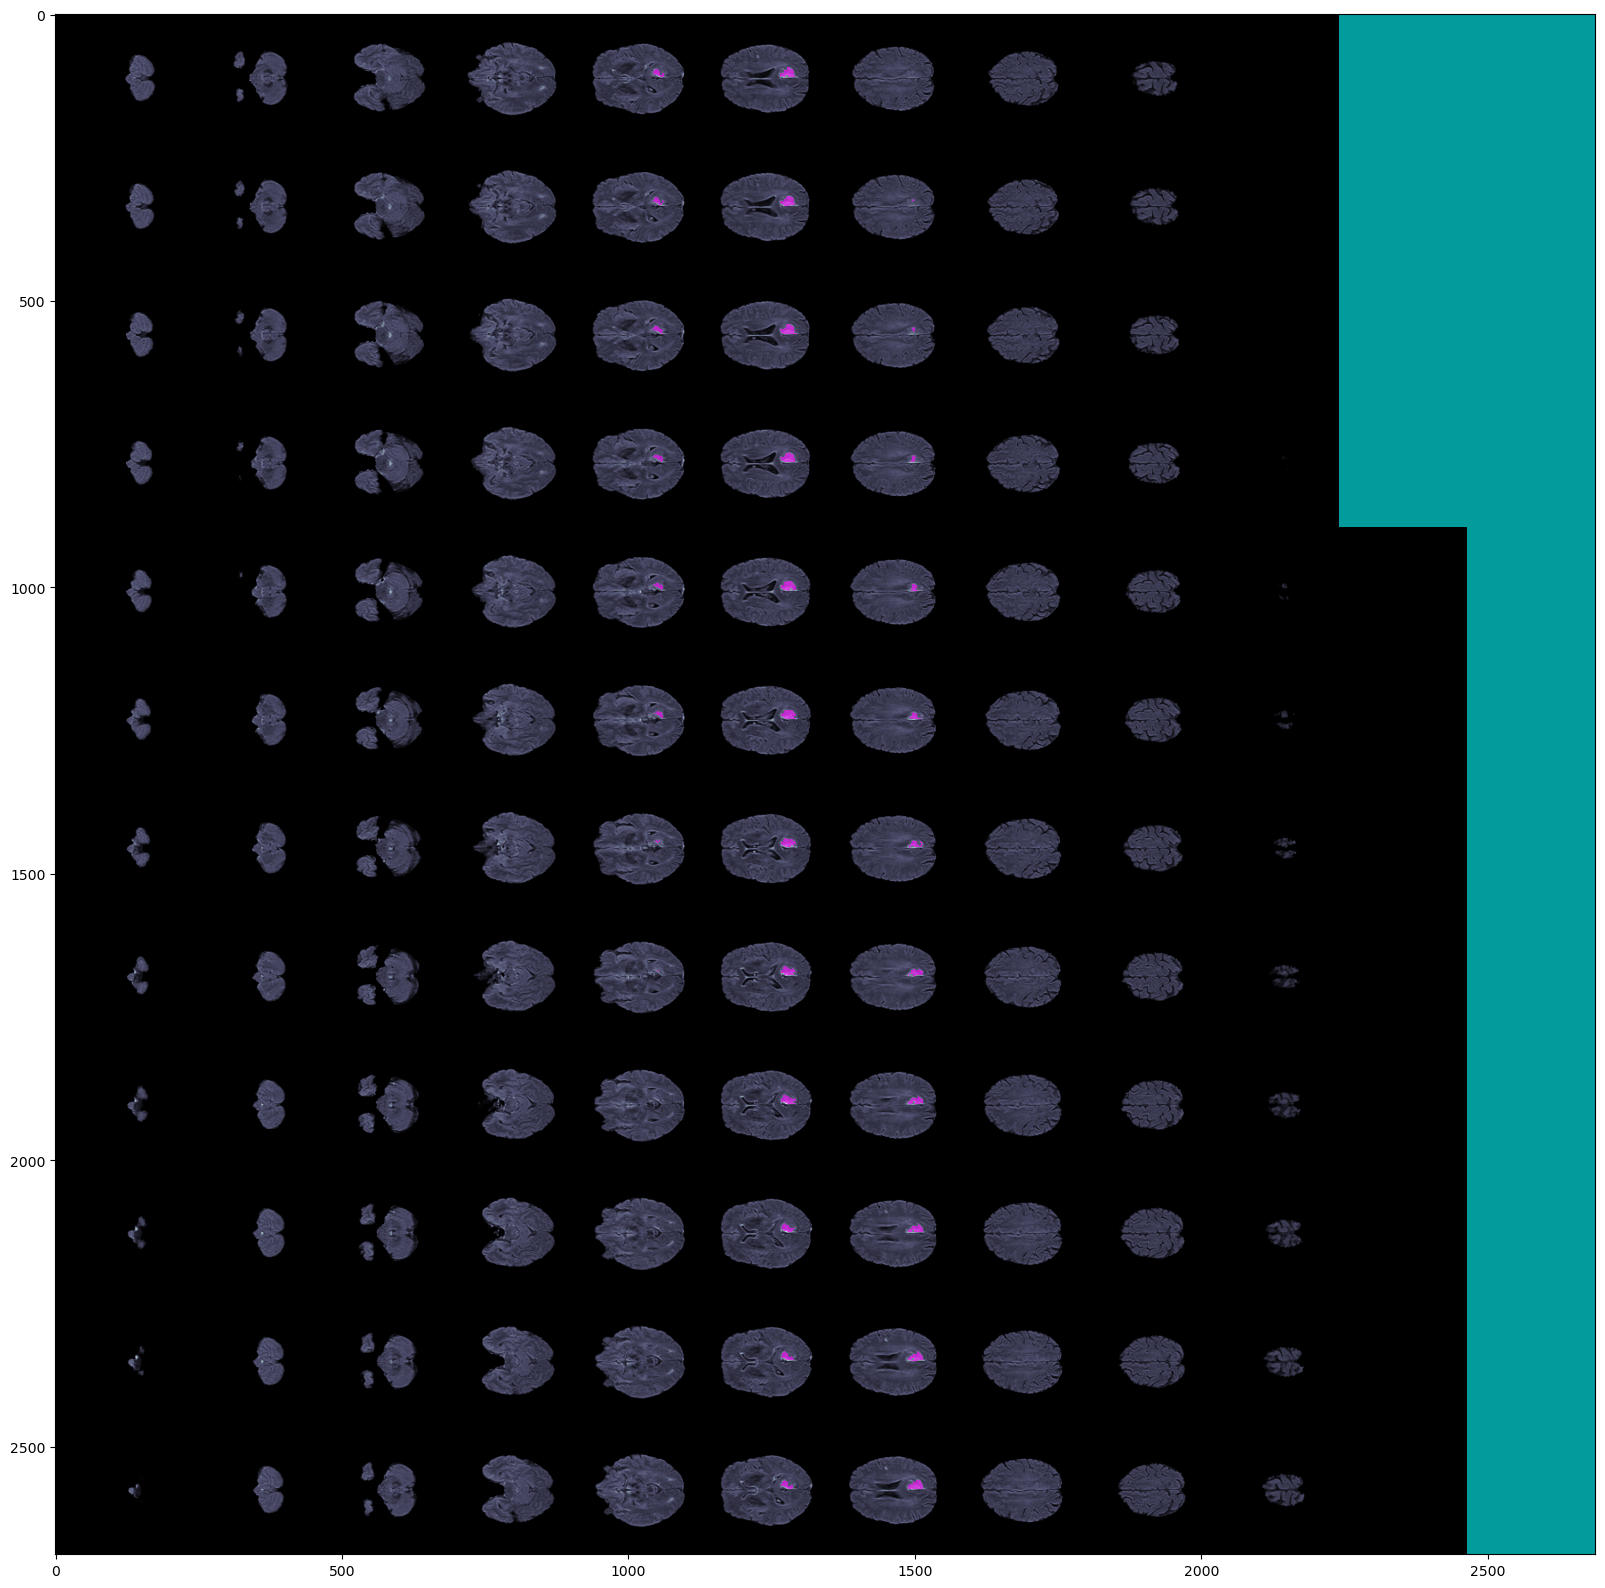

In [17]:
img_tensor = data['image'].squeeze()[0].cpu().detach().numpy() 
mask_tensor = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()
print("Num uniq Image values :", len(np.unique(img_tensor, return_counts=True)[0]))
print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
print("Num uniq Mask values:", np.unique(mask_tensor, return_counts=True))
print(img_tensor.shape)
image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor)) 

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6)

# Training

## TO-DO: Train your own model; experiment with different hyperparameters

### **Optional**: If you don't want to train from scratch, download the 3DUnet model checkpoint trained by the author of the [referenced notebook](https://www.kaggle.com/code/polomarco/brats20-3dunet-3dautoencoder/notebook) and place it in the same path as `config.pretrained_model_path`

### Alternatively, train your own model and reload it from the same place.

In [18]:
"""Uncomment these to clear GPU VRAM"""
# del model
torch.cuda.empty_cache()
torch.cuda.synchronize()
# assert(0==1)

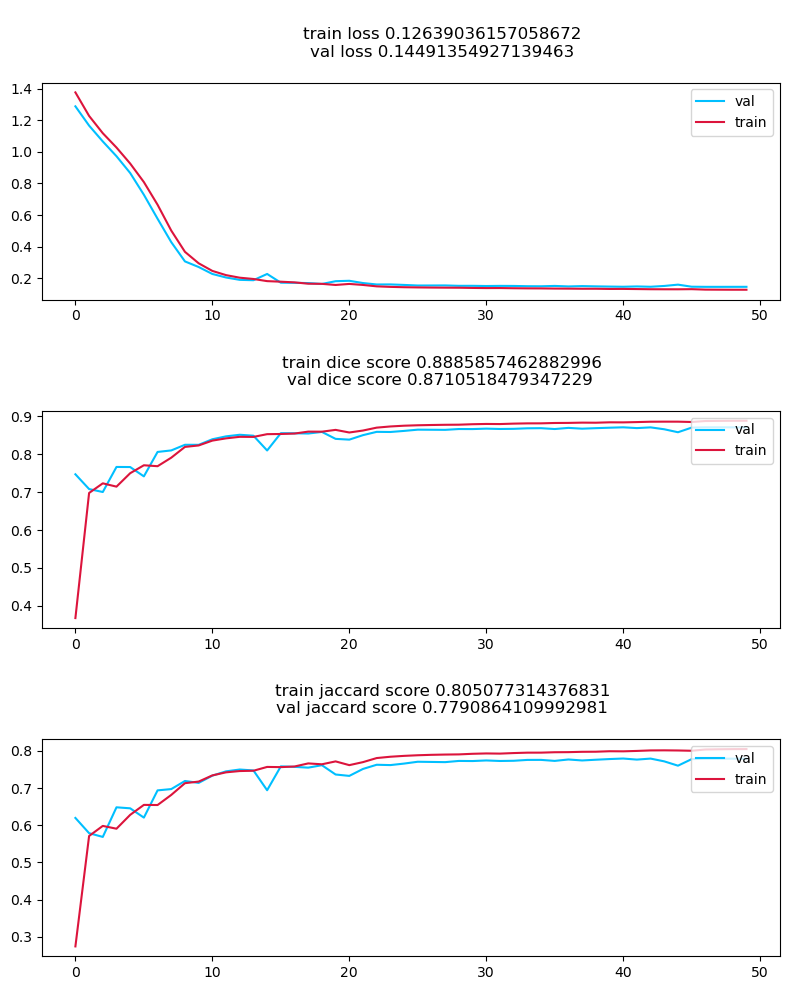

In [19]:
# assert(0==1)
"""UNCOMMENT THIS TO START TRAINING"""
trainer.run()



In [20]:
# write logs to train_logs_path
with open(os.path.join(config.train_logs_path, 'trainer_properties.txt'), 'w') as f:
  for param, value in trainer.__dict__.items():
      if not param.startswith("__"):
        f.write(f"{param}:{value}\n")


# Evaluation and Results

In [21]:
def compute_scores_per_classes(model,
                               dataloader,
                               classes):
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes


In [22]:
# test_dataloader = get_dataloaders(dataset=BratsDataset, path_to_csv=config.path_to_csv, val_fold=0, test_fold=1, batch_size=1)
len(dataloader)

263

In [23]:
model.eval()
print()

In [24]:
# %%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    model, test_dataloader, ['WT', 'TC', 'ET']
    )

In [25]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard', 
                                      'TC dice', 'TC jaccard', 
                                      'ET dice', 'ET jaccard']]
val_metics_df.sample(5)

,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard
19,0.960838,0.924627,0.960883,0.924712,1.0,1.0
41,0.916999,0.846721,0.916685,0.846185,1.0,1.0
47,0.903058,0.823250,0.903848,0.824564,1.0,1.0
12,0.888016,0.798588,0.886328,0.795861,1.0,1.0
43,0.950768,0.906156,0.950917,0.906426,1.0,1.0


In [26]:
val_metics_df


,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard
0,8.854753e-01,7.944869e-01,8.863600e-01,7.959126e-01,1.0,1.0
1,9.563620e-01,9.163733e-01,9.572932e-01,9.180848e-01,1.0,1.0
2,8.980100e-01,8.148985e-01,8.979094e-01,8.147329e-01,1.0,1.0
3,8.923202e-01,8.055760e-01,8.926913e-01,8.061810e-01,1.0,1.0
4,9.423052e-01,8.909046e-01,9.422298e-01,8.907699e-01,1.0,1.0
5,8.684729e-01,7.675229e-01,8.690122e-01,7.683656e-01,1.0,1.0
6,8.943281e-01,8.088548e-01,8.940986e-01,8.084795e-01,1.0,1.0
7,9.677076e-15,9.677076e-15,9.685699e-15,9.685699e-15,1.0,1.0
8,7.056108e-01,5.451303e-01,7.042292e-01,5.434828e-01,1.0,1.0
9,9.238221e-01,8.584287e-01,9.233121e-01,8.575485e-01,1.0,1.0


In [27]:
val_metics_df.to_csv(os.path.join(
    config.train_logs_path, "test_results.csv"))
val_metics_df.mean().to_csv(os.path.join(config.train_logs_path, "test_results_mean.csv"))


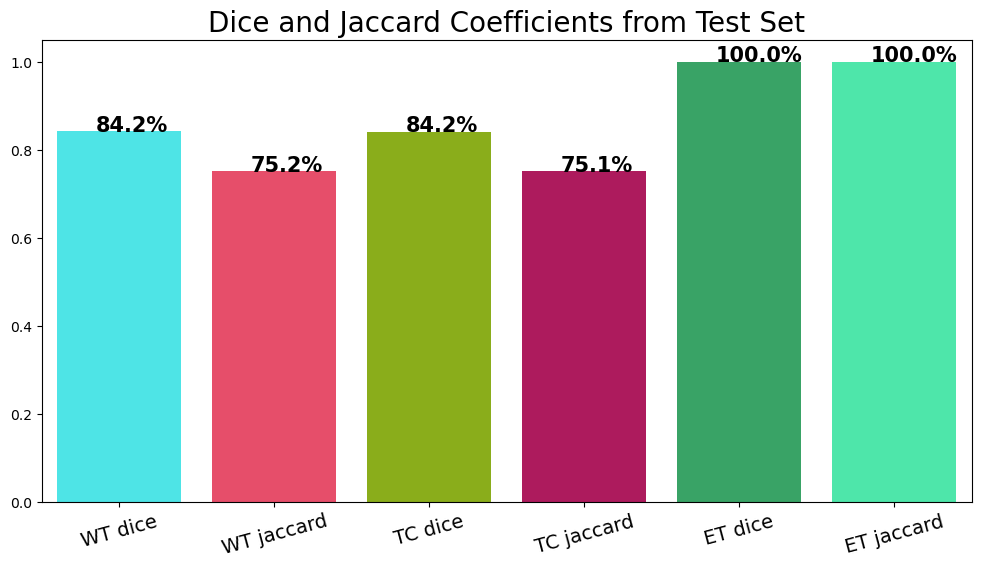

In [28]:
colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15);
ax.set_title("Dice and Jaccard Coefficients from Test Set", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig(os.path.join(config.train_logs_path, "result.png"), format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig(os.path.join(config.train_logs_path, "result.svg"), format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')


## More visualization

In [29]:
def compute_results(model,
                    dataloader,
                    treshold=0.33):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results = {"Id": [],"image": [], "GT": [],"Prediction": []}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            id_, imgs, targets = data['Id'], data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits)
            
            predictions = (probs >= treshold).float()
            predictions =  predictions.cpu()
            targets = targets.cpu()
            
            results["Id"].append(id_)
            results["image"].append(imgs.cpu())
            results["GT"].append(targets)
            results["Prediction"].append(predictions)
            
            # only 5 pars
            if (i > 5):    
                return results
        return results

In [30]:
# %%time
results = compute_results(
    model, test_dataloader, 0.33)

['BraTS20_Training_368']
[0. 1.]
[0. 1.]


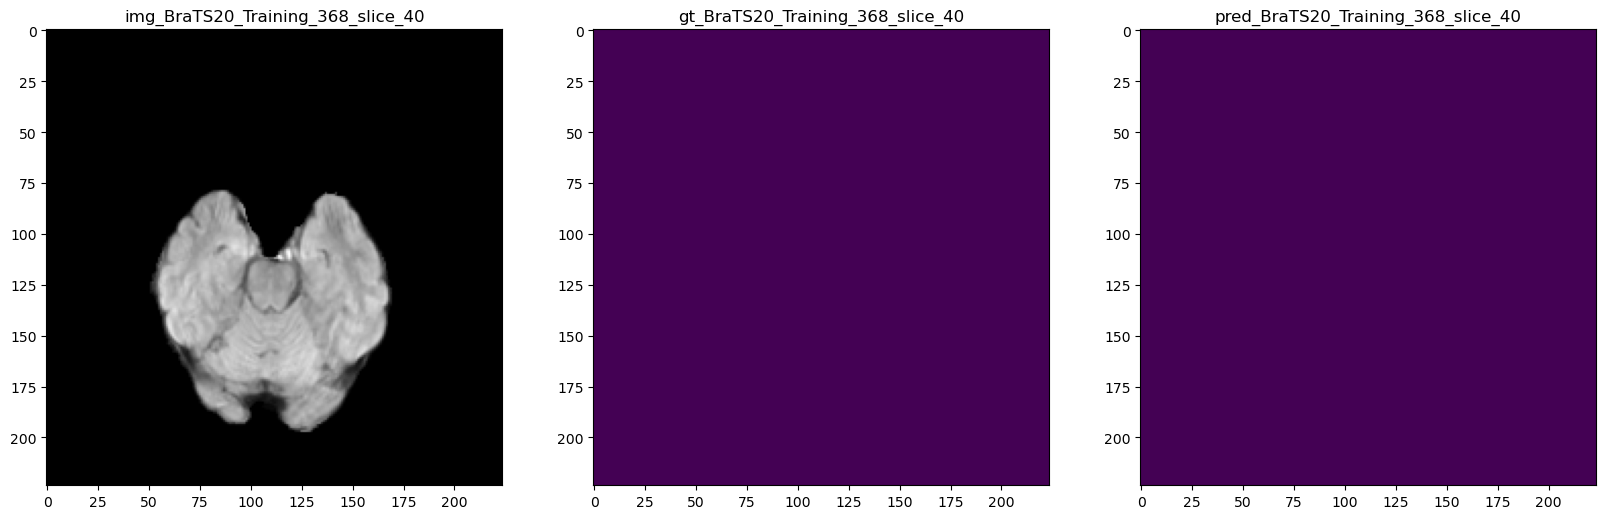

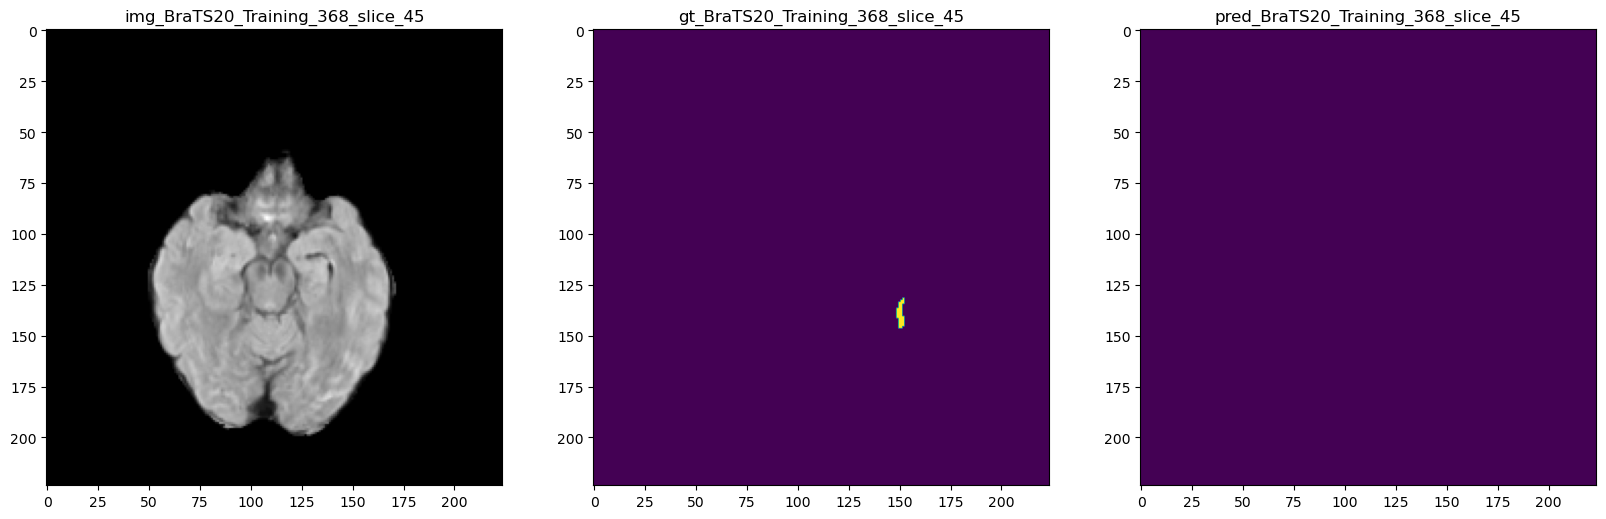

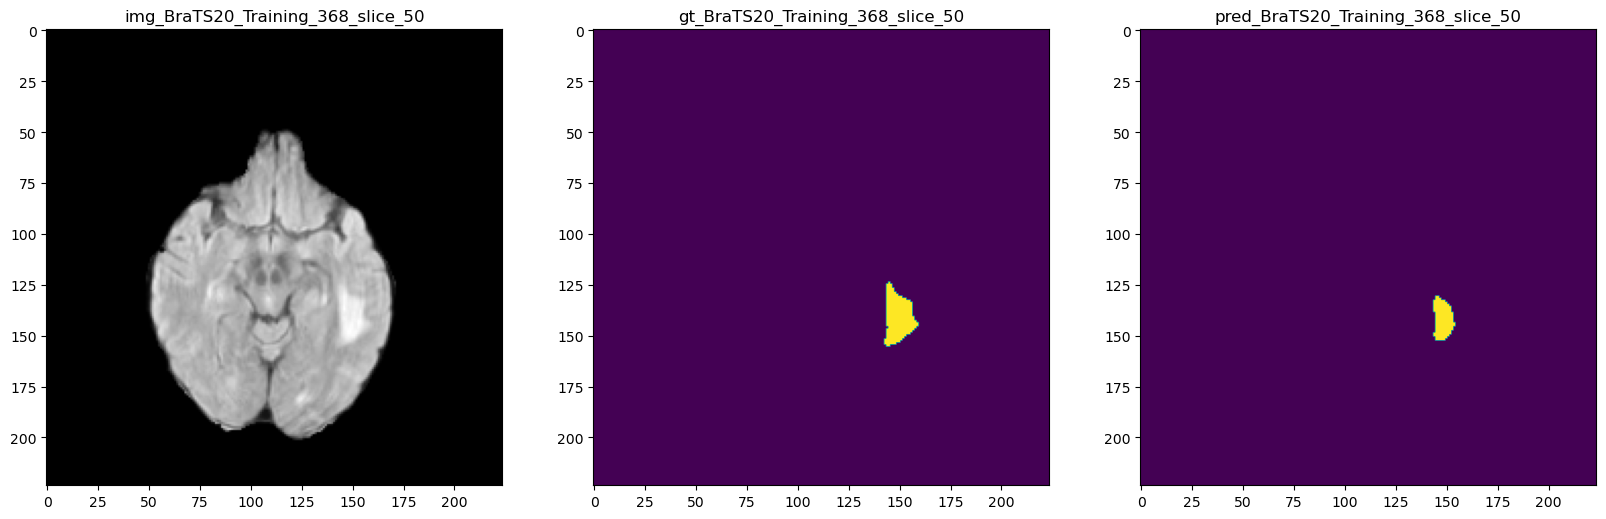

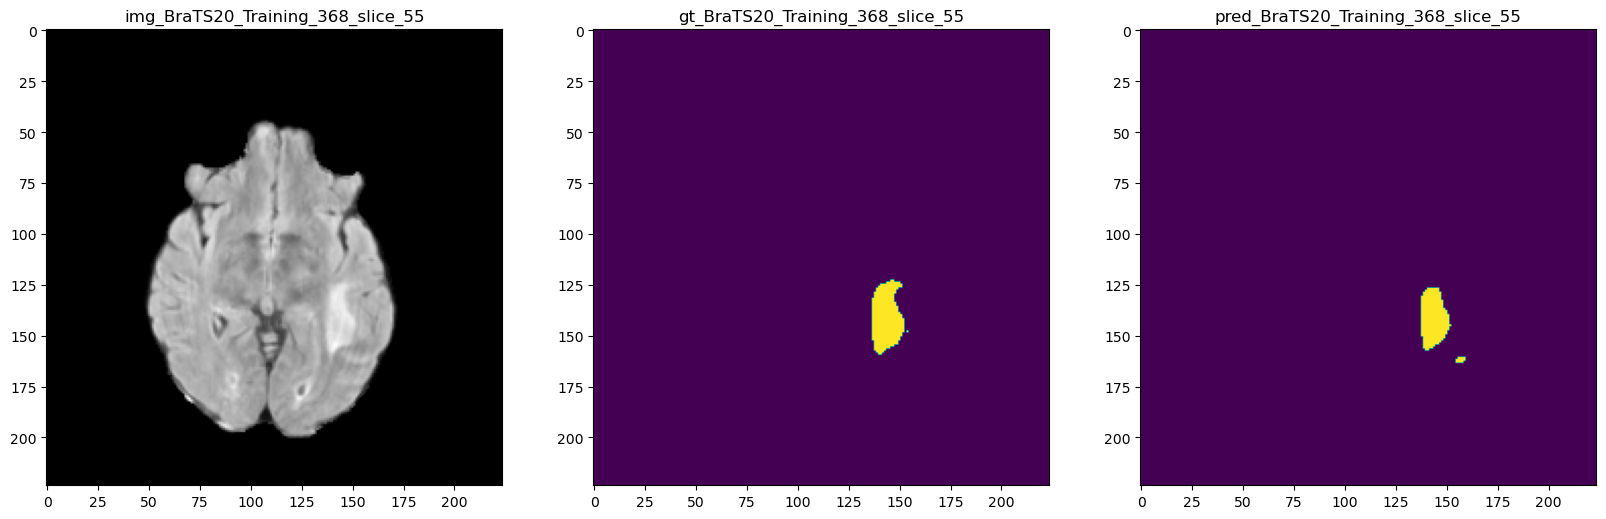

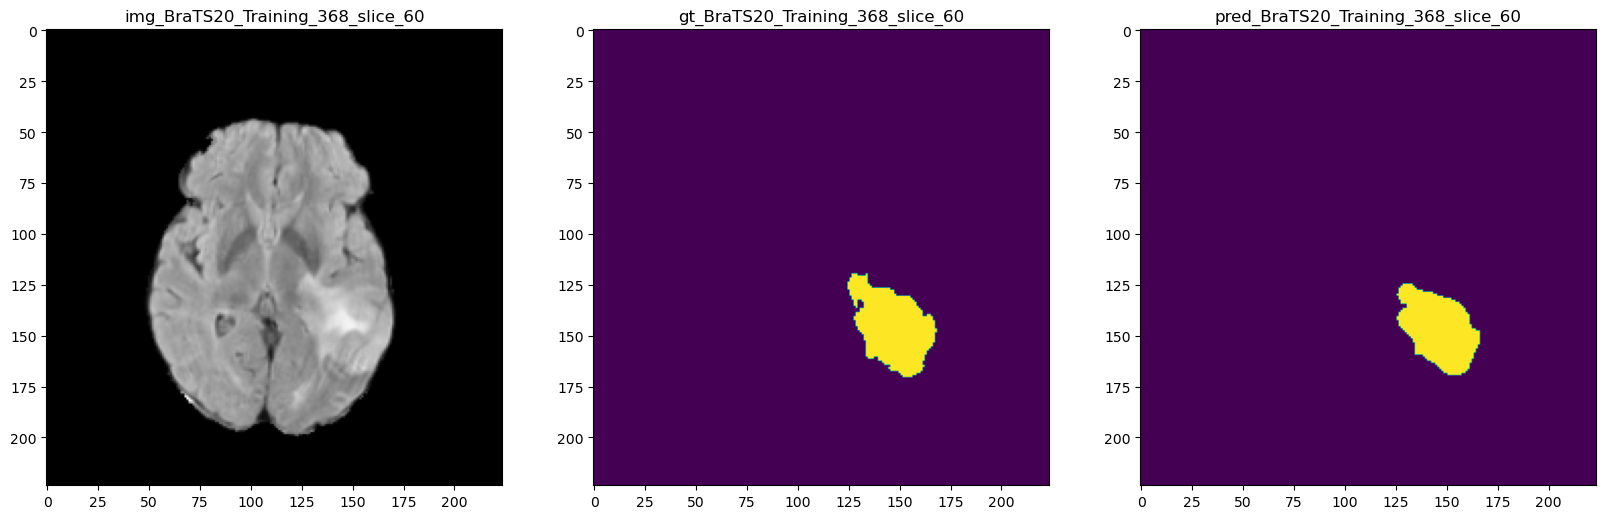

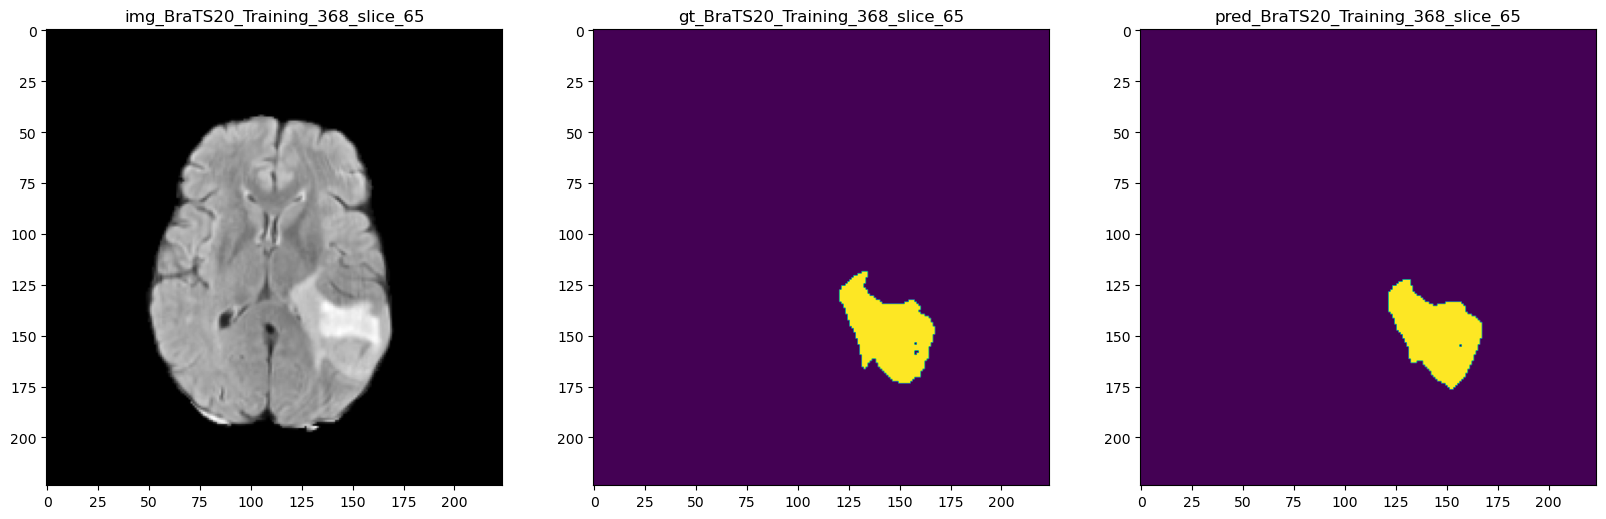

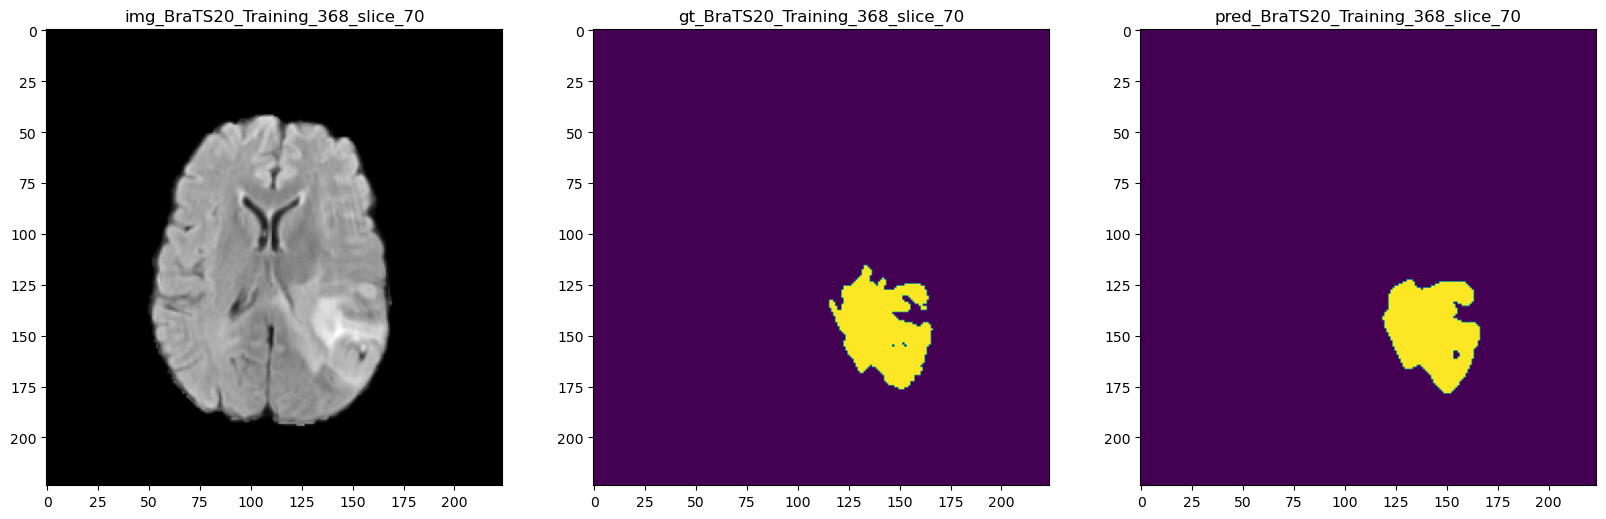

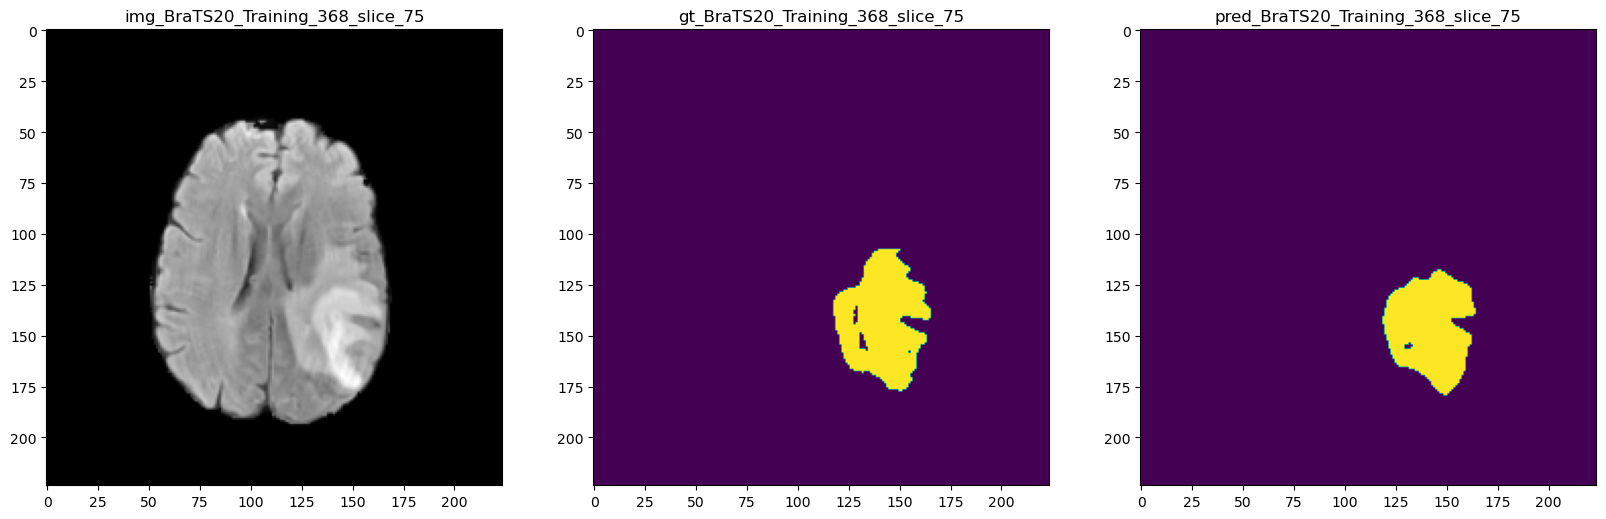

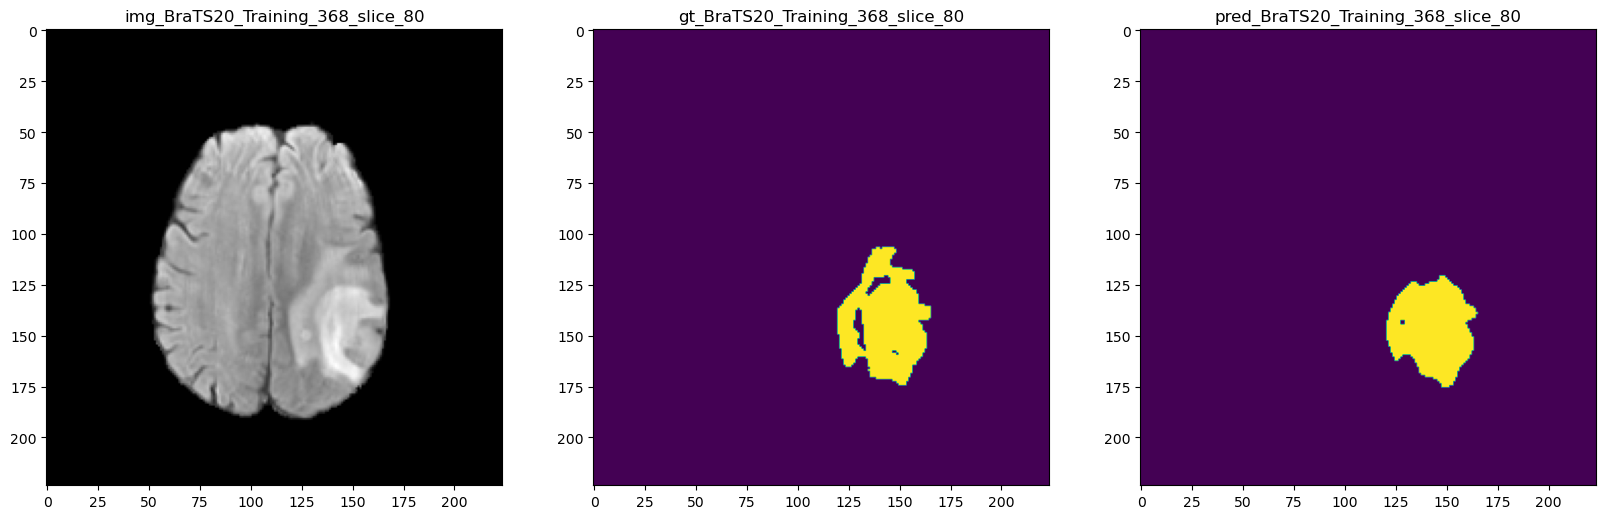

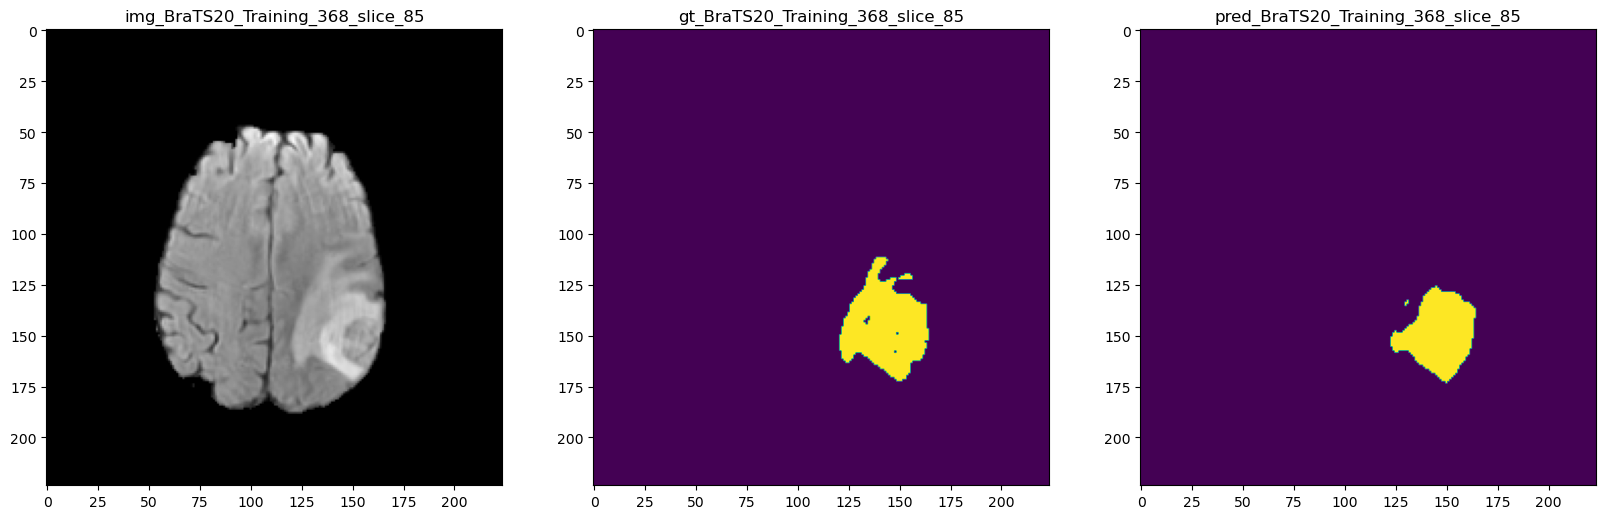

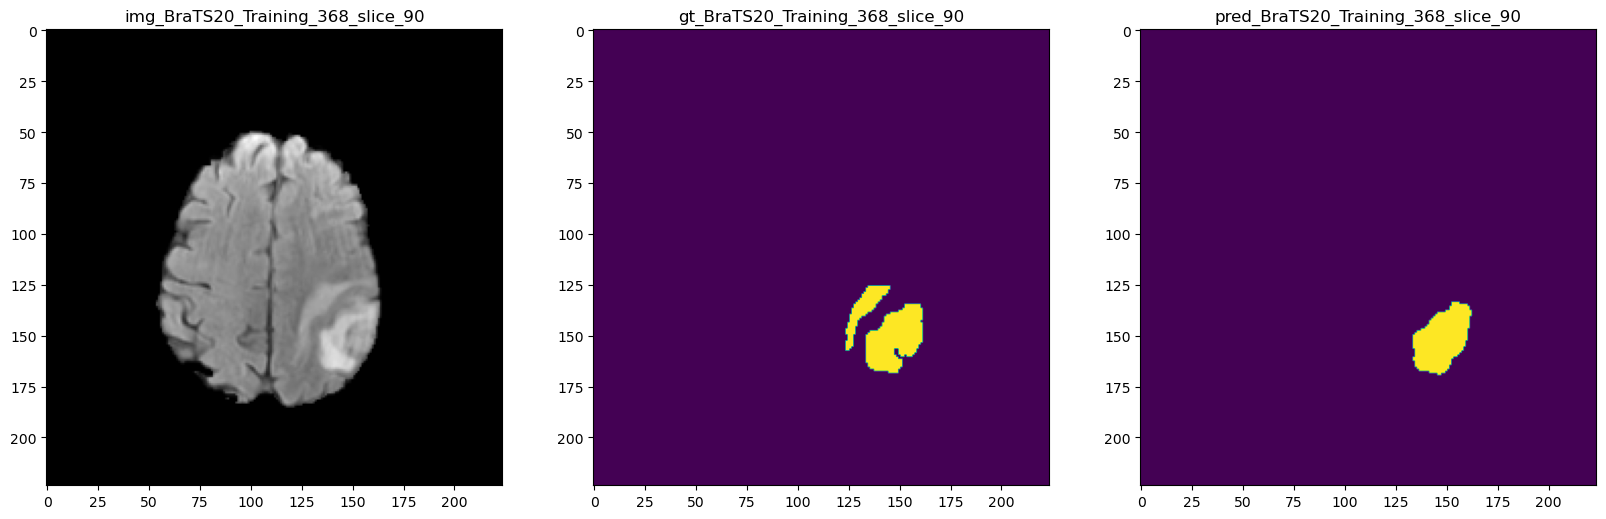

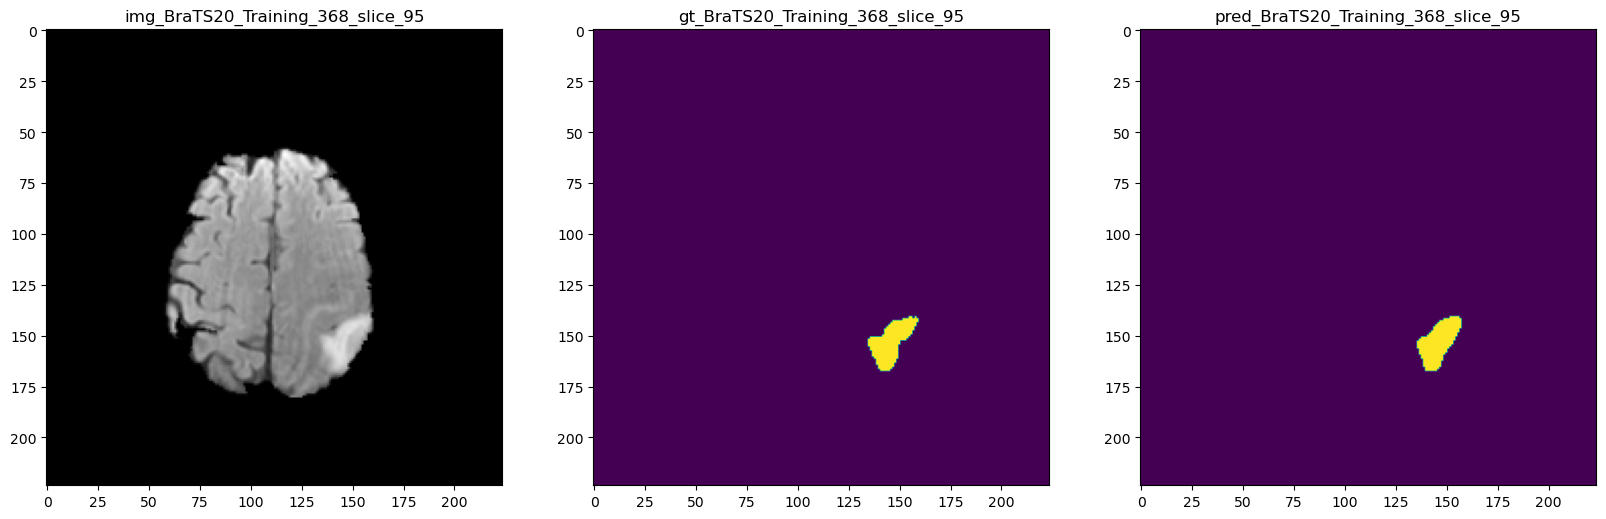

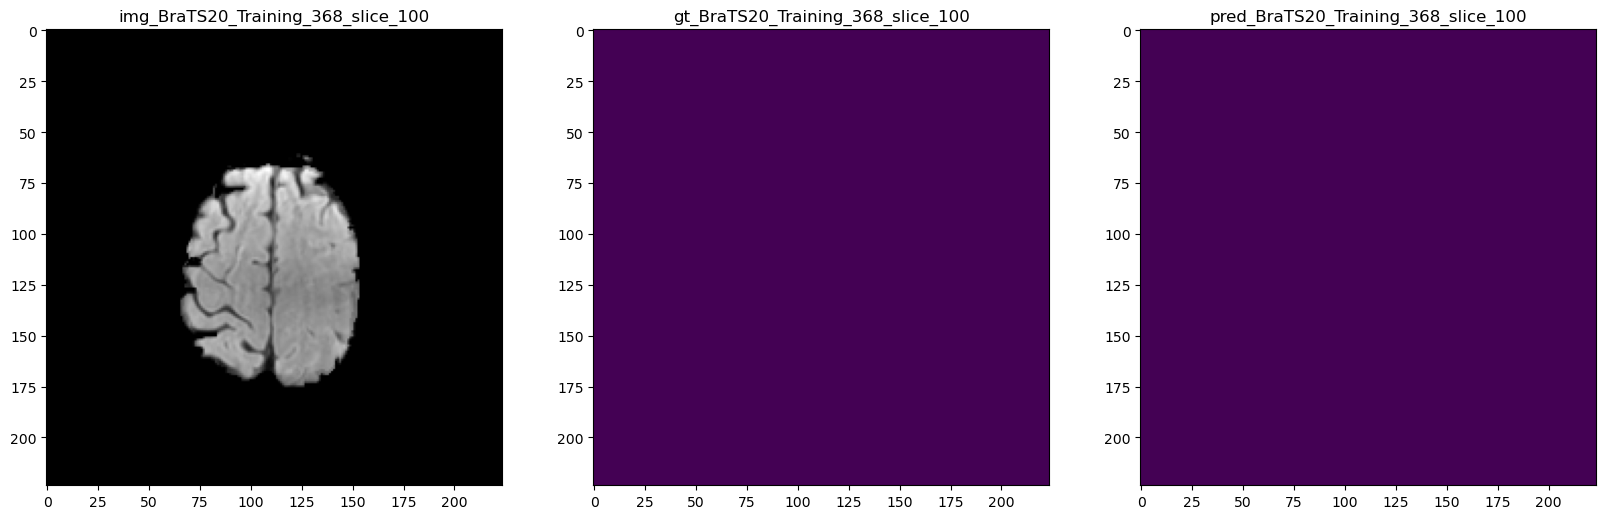

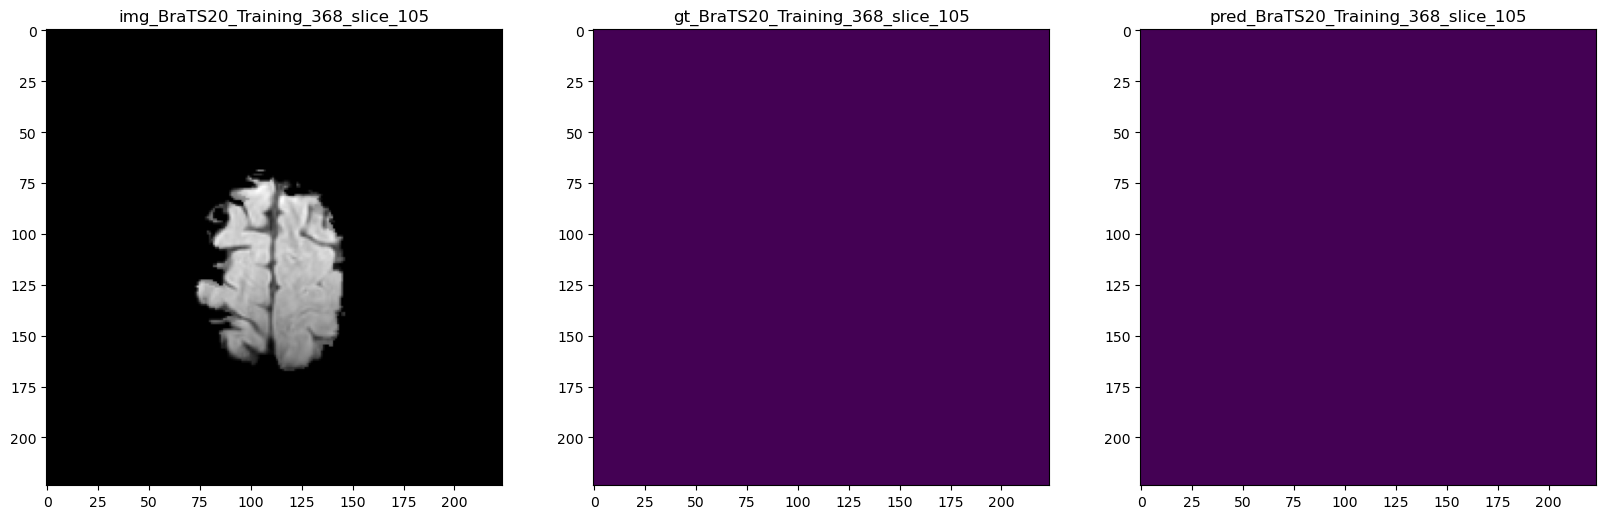

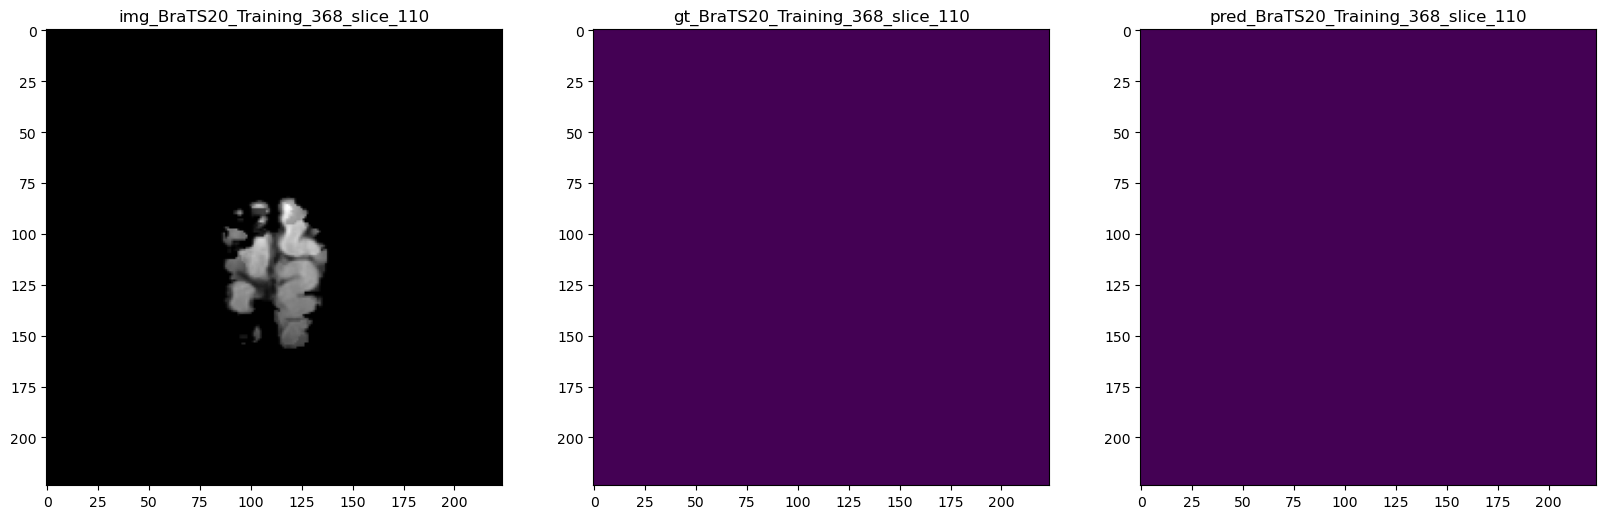

In [31]:
for id_, img, gt, prediction in zip(results['Id'][4:],
                    results['image'][4:],
                    results['GT'][4:],
                    results['Prediction'][4:]
                    ):
    
    print(id_)
    name = id_[0]
    # print(img.shape)
    # print(gt.shape)
    # print(gt.unique())
    # print(prediction.shape)
    # print(prediction.unique())
    img = img.squeeze()[0].cpu().detach().numpy()
    gt = gt.squeeze()[0].squeeze().cpu().detach().numpy()
    prediction = prediction.squeeze()[0].squeeze().cpu().detach().numpy()
    # img.reshape((240,240,155))
    # gt.reshape((240, 240, 155))
    # prediction.reshape((240, 240, 155))
    # print(np.unique(img))
    print(np.unique(gt))
    print(np.unique(prediction))
    
    
    for i in range(40,110+1,5):
      fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
      slice_w = i
      ax1.imshow(img[slice_w, :, :], cmap="gray")
      ax1.set_title(f'img_{name}_slice_{i}')
      ax2.imshow(gt[slice_w, :, :])
      ax2.set_title(f'gt_{name}_slice_{i}')
      ax3.imshow(prediction[slice_w, :, :])
      ax3.set_title(f'pred_{name}_slice_{i}')
      fig.savefig(os.path.join(config.train_logs_path, f"prediction_{name}_slice_{i}.png"),
                  format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
    break
    